<a href="https://colab.research.google.com/github/MateoProjects/TFM/blob/main/Training_Dalle_2_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test Dalle implementation using Pytorch

**Source**: https://github.com/lucidrains/dalle2-pytorch

This is a notebook that follows and implements the tutorial that can be found on the Github provided above.



The main purpose of these project is learn and understand how images can be conditioned based on the input text, bias etc... 

\


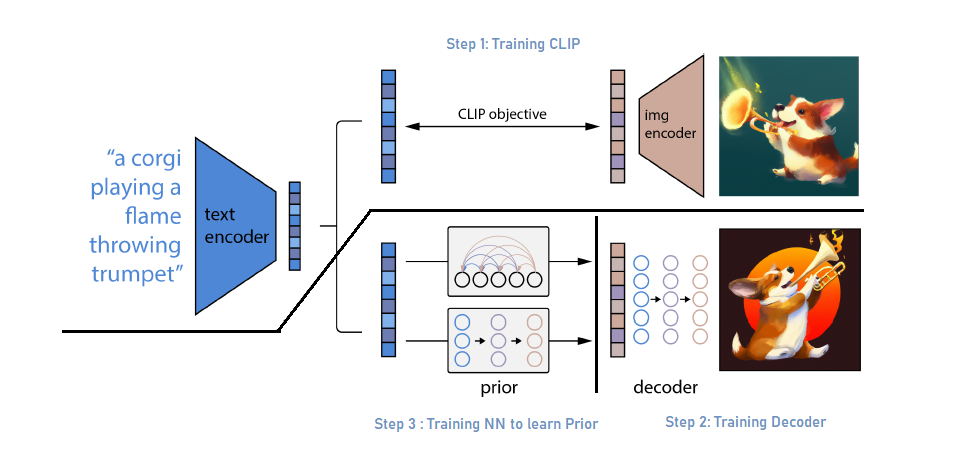

\

**Note:** Step 2 and 3 can be do it in different order. Don't exists any dependence between both steps. 

## Instalation

In [ ]:
!pip install -qq dalle2-pytorch

## Step 1: Training CLIP

This clip is an implementation of a recents papers published. This implementation was made it by Lucidrains called x-clip

In [2]:
import torch
from dalle2_pytorch import CLIP

clip = CLIP(
    dim_text = 512,
    dim_image = 512,
    dim_latent = 512,
    num_text_tokens = 49408,
    text_enc_depth = 1,
    text_seq_len = 256,
    text_heads = 8,
    visual_enc_depth = 1,
    visual_image_size = 256,
    visual_patch_size = 32,
    visual_heads = 8,
    use_all_token_embeds = True,            # whether to use fine-grained contrastive learning (FILIP)
    decoupled_contrastive_learning = True,  # use decoupled contrastive learning (DCL) objective function, removing positive pairs from the denominator of the InfoNCE loss (CLOOB + DCL)
    extra_latent_projection = True,         # whether to use separate projections for text-to-image vs image-to-text comparisons (CLOOB)
    use_visual_ssl = True,                  # whether to do self supervised learning on images
    visual_ssl_type = 'simclr',             # can be either 'simclr' or 'simsiam', depending on using DeCLIP or SLIP
    use_mlm = False,                        # use masked language learning (MLM) on text (DeCLIP)
    text_ssl_loss_weight = 0.05,            # weight for text MLM loss
    image_ssl_loss_weight = 0.05            # weight for image self-supervised learning loss
).cuda()

# mock data

text = torch.randint(0, 49408, (4, 256)).cuda()
images = torch.randn(4, 3, 256, 256).cuda()

# train

loss = clip(
    text,
    images,
    return_loss = True              # needs to be set to True to return contrastive loss
)

loss.backward()

## Step 2: Training a decoder

In [ ]:
# unet for the decoder
from dalle2_pytorch import Unet, Decoder

unet = Unet(
    dim = 128,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults=(1, 2, 4, 8)
).cuda()

# decoder, which contains the unet and clip

decoder = Decoder(
    unet = unet,
    clip = clip,
    timesteps = 100,
    image_cond_drop_prob = 0.1,
    text_cond_drop_prob = 0.5
).cuda()

# mock images (get a lot of this)

images = torch.randn(4, 3, 256, 256).cuda()

# feed images into decoder

loss = decoder(images)
loss.backward()

## Step 3: Train the Prior Network

In [ ]:
from dalle2_pytorch import DiffusionPriorNetwork, DiffusionPrior

prior_network = DiffusionPriorNetwork(
    dim = 512,
    depth = 6,
    dim_head = 64,
    heads = 8
).cuda()

# diffusion prior network, which contains the CLIP and network (with transformer) above

diffusion_prior = DiffusionPrior(
    net = prior_network,
    clip = clip,
    timesteps = 100,
    cond_drop_prob = 0.2
).cuda()

# mock data

text = torch.randint(0, 49408, (4, 256)).cuda()
images = torch.randn(4, 3, 256, 256).cuda()

# feed text and images into diffusion prior network

loss = diffusion_prior(text, images)
loss.backward()

## Generating images from text

In [ ]:
from dalle2_pytorch import DALLE2

dalle2 = DALLE2(
    prior = diffusion_prior,
    decoder = decoder
)

# send the text as a string if you want to use the simple tokenizer from DALLE v1
# or you can do it as token ids, if you have your own tokenizer

texts = ['glistening morning dew on a flower petal']
images = dalle2(texts) # (1, 3, 256, 256)